In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np

from highspeed10 import SerialCommunication, PCF8575Control_, MFCControl

In [2]:
# Serial port configuration
PORT = "/dev/ttyACM0"  # Replace with your Teensy's serial port
BAUDRATE = 115200  # Match the baud rate used in the Teensy program
PACKET_SIZE = 128  # Size of each data packet (bytes)
DURATION = 10  # Duration of the recording (seconds)
FREQUENCY = 1  # Sampling frequency (Hz)

#PCF8575 configuration
PCF_flags = [True for i in range(16)]           # All sensors ON
PCF_frequencies = ["0" for i in range(16)]      # All sensors at 0Hz

# DAC configuration
dac1_value = 800
dac2_value = 200

sensor_id = ["U1-TGS2602", "U2-TGS2610-D00", "U3-SP3S-AQ2", "U4-GSBT11-DXX",
             "U8-TGS2600", "U9-TGS2603", "U10-TGS2630", "U13-TGS2612-D00",
             "U14-TGS2620", "U15-MG-812", "U16-TGS-3830", "U19-TGS1820",
             "U20-TGS2611-E00", "U21-TGS2616-C00", "U22-WSP2110", "U25-TGS-3870",
             "U7-BME680"]

sensor_addr = [[0x49, 1],[0x49, 3],[0x4b, 2],[0x4b, 3],
               [0x49, 0],[0x49, 2],[0x4b, 0],[0x48, 1],
               [0x48, 3],[0x4a, 1],[0x4a, 3],[0x4a, 2],
               [0x48, 0],[0x48, 2],[0x4a, 0],[0x4b, 1],
               [0x76, 99]]

sensor_addr_to_tag = [[0x49, 0], [0x4b, 1], [0x48, 2], [0x4a, 3],]

adc_addr = [0x48, 0x49, 0x4a, 0x4b]

# Setting up the serial communication
serial_comm = SerialCommunication(PORT, BAUDRATE)

# Setting up DAC values and sampling frequency
message = f"{dac1_value},{dac2_value},{FREQUENCY}\n"
serial_comm.send_message(message)

# Setting the PCF8575 state
PCF_control = PCF8575Control_(serial_comm, flags=PCF_flags, frequencies=PCF_frequencies)
PCF_control.send_state()

# Setting MFCs
MFC_control = MFCControl(serial_comm)
time.sleep(3)
MFC_control.set_flow(3,55)
time.sleep(10)
MFC_control.set_flow(3,0.)

# time.sleep(60)
# MFC_control.set_flow(1,0.)
# MFC_control.set_flow(3,0.)

# # Recording sensor data
# data = []
# serial_comm.is_running = True
# for read in serial_comm.stream_data(DURATION, save_csv=False):
#     data.append(read)
# serial_comm.is_running = False



Sent to Teensy: 800,200,1
Sent to Teensy: PCF,64575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PCF8575 state and frequencies updated:
State: 0b1111110000111111
Frequencies: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sent to Teensy: MFC,1,1,0.0
MFC 1 flow rate updated: 0.0
Sent to Teensy: MFC,1,0
Sent to Teensy: MFC,2,1,0.0
MFC 2 flow rate updated: 0.0
Sent to Teensy: MFC,2,0
Sent to Teensy: MFC,3,1,0.0
MFC 3 flow rate updated: 0.0
Sent to Teensy: MFC,3,0
Sent to Teensy: MFC,3,1,55
MFC 3 flow rate updated: 55
Sent to Teensy: MFC,3,0
Sent to Teensy: MFC,3,1,0.0
MFC 3 flow rate updated: 0.0
Sent to Teensy: MFC,3,0


/tmp/ipykernel_101309/1994940018.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[i,j].set_xticks([])
/tmp/ipykernel_101309/1994940018.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[i,j].set_xticks([])
/tmp/ipykernel_101309/1994940018.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax[i,j].set_xticks([])
/tmp/ipykernel_101309/1994940018.py:14: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instea

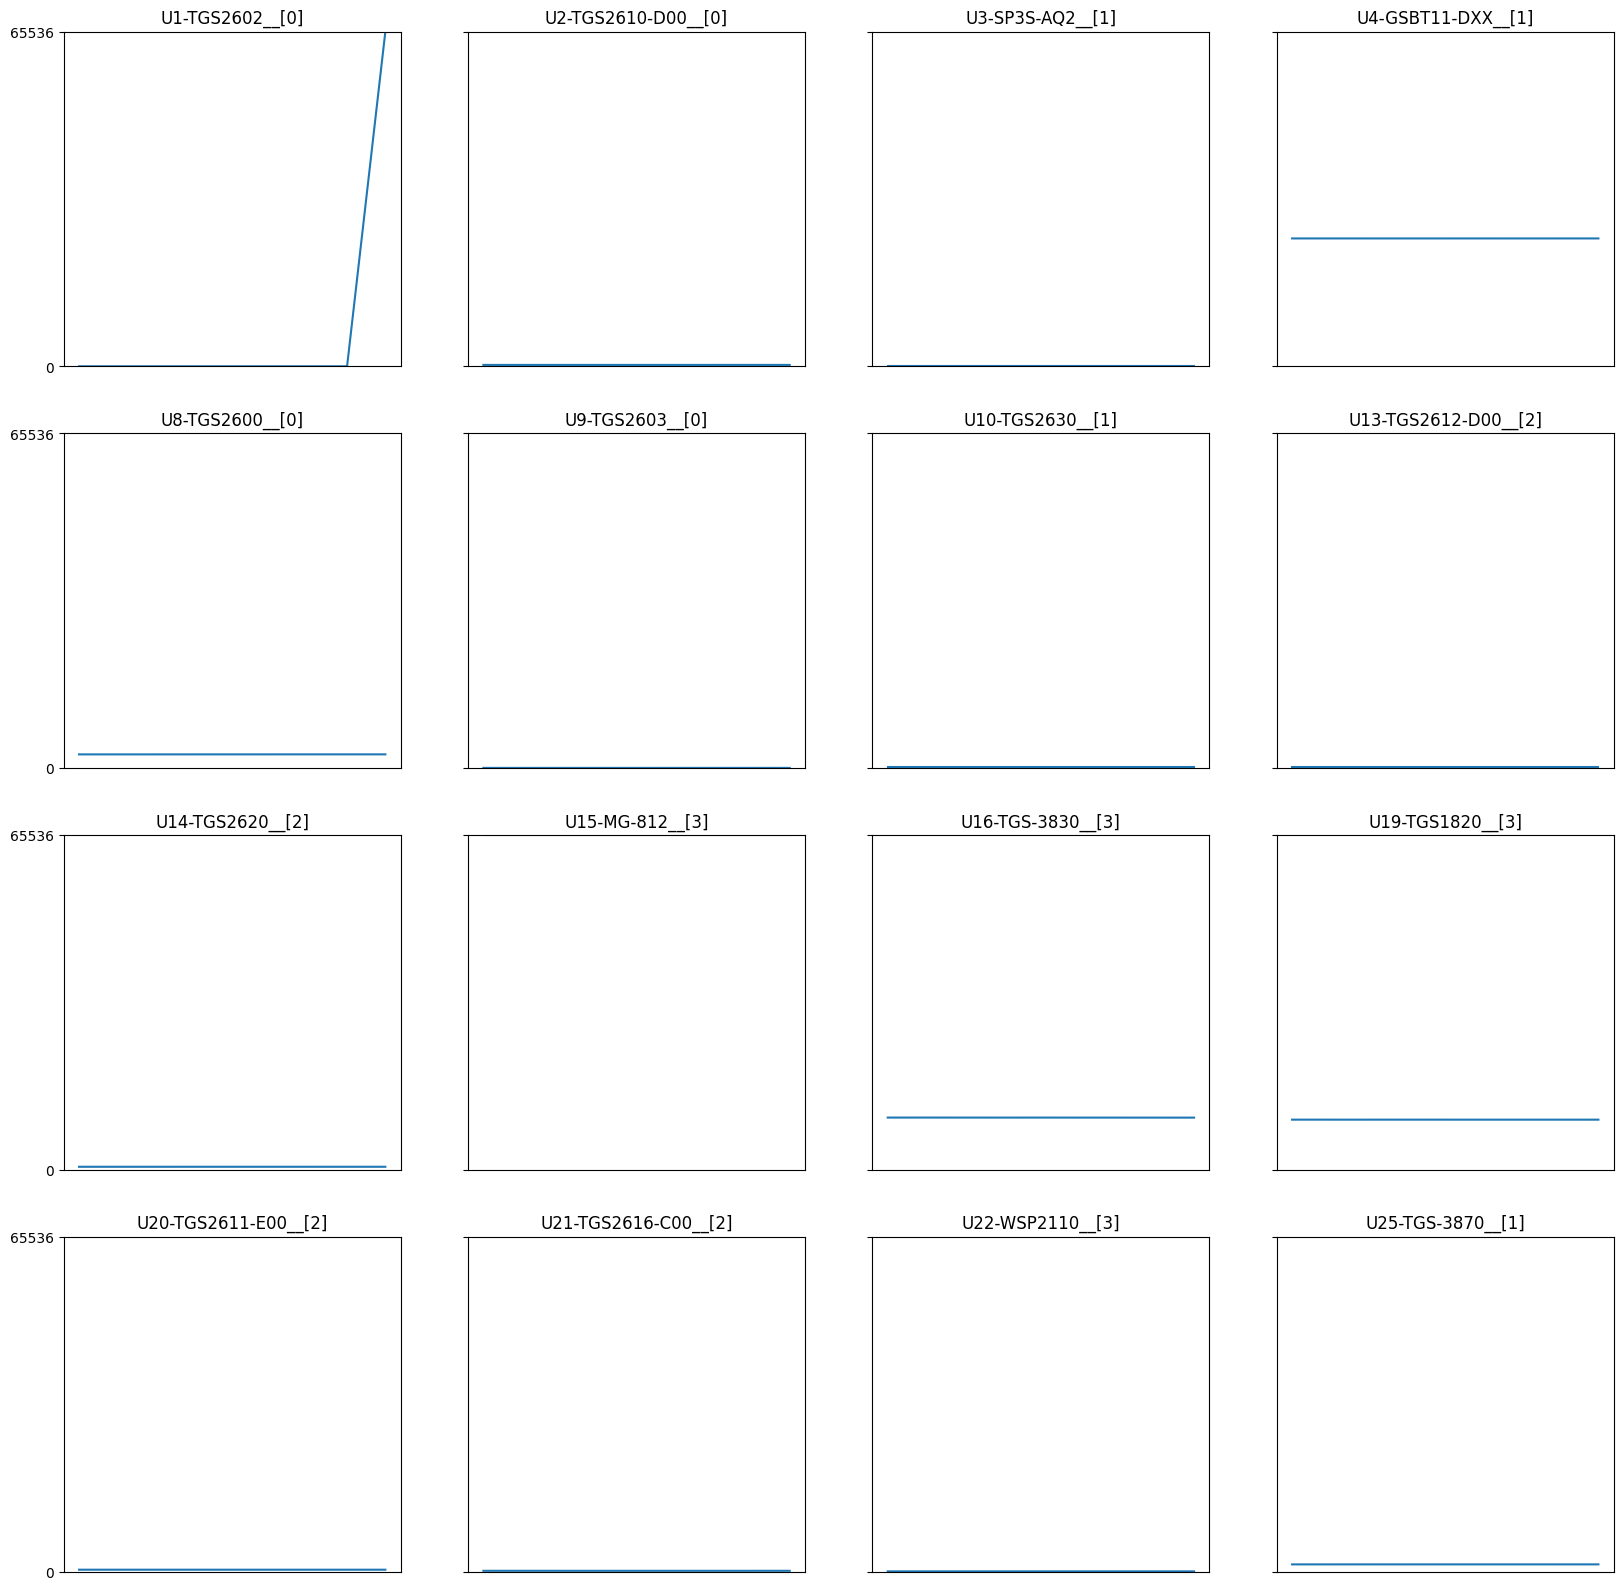

In [4]:
times = [read[0] for read in data]

sensor_data = []
for i in range(16):
    values = []
    for read in data:
        values.append(int.from_bytes(read[2*i+1:2*i+3], byteorder="little"))    # Check with Herman
    sensor_data.append(values)

fig, ax = plt.subplots(4,4, figsize=(20,20), sharey=True)
for i in range(4):
    for j in range(4):
        ax[i,j].plot(times, sensor_data[i*4+j])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([0, 2**16])
        ax[i,j].set_ylim([0, 2**16])
        adc_idx = [tag[1] for tag in sensor_addr_to_tag if sensor_addr[i*4+j][0] == tag[0]]
        ax[i,j].set_title(f'{sensor_id[i*4+j]}__{adc_idx}')

In [147]:
import pickle
with open('data/data_test.pkl', 'wb') as f:
    pickle.dump(sensor_data, f)

In [148]:
sensor_data = pickle.load(open('data/data_test.pkl', 'rb'))

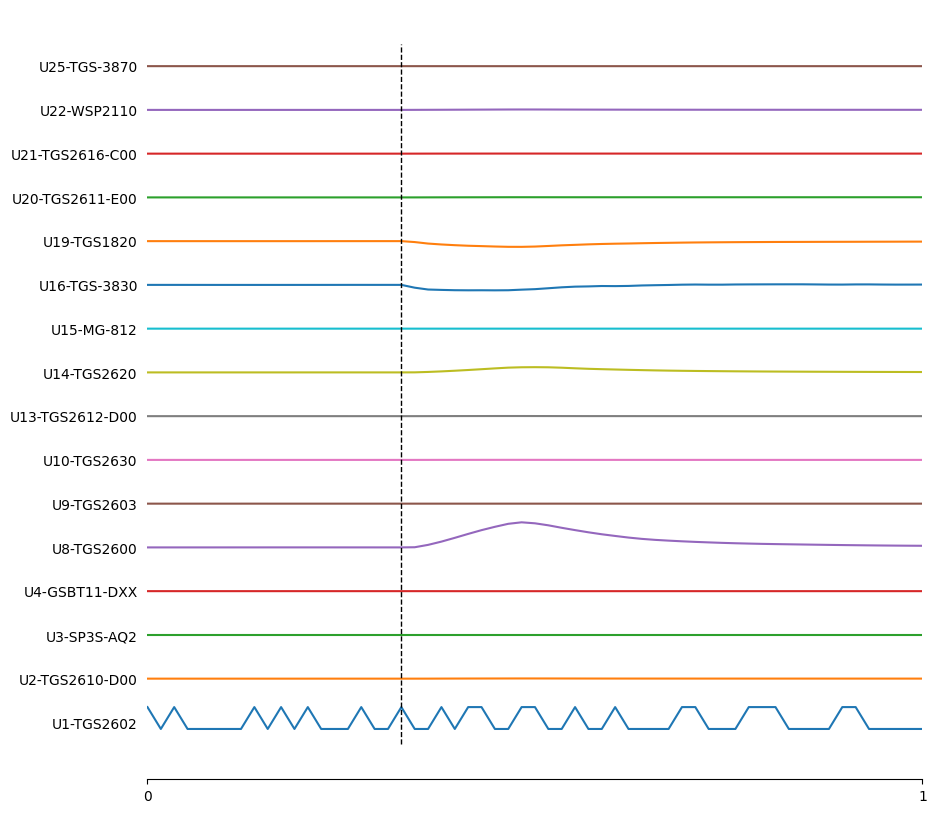

In [162]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i, row in enumerate(sensor_data):
    baseline = np.mean(row[:10])
    signal = (np.array(row) - baseline)/65536.
    if i==0:
        ax.plot(times, signal, label=sensor_id[i])
    else:
        ax.plot(times, signal*10 + 2*i , label=sensor_id[i+1])
ax.set_yticks(2*np.arange(16), labels=sensor_id[:-1])
ax.set_xticks([times[0], times[-1]], labels=[0,1])
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.tick_params(left=False, labelleft=True)
ax.set_xlim([times[0], times[-1]])
ax.vlines(19, linestyles='dashed', ymin=-1, ymax=31, colors='black', linewidth=1.)
plt.savefig('figs/test.png', dpi=300)

In [137]:
len(times)

59